In [18]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
from monai.transforms import Compose, ScaleIntensity, Resize, ToTensor
from PIL import Image
import os
import glob


# Define Dataset Root Path
DATASET_ROOT = r"C:\Users\HP5CD\Desktop\Project exhibition\DATASET\Bone Break Classification\Bone Break Classification"

# Automatically detect fracture types
fracture_types = [folder for folder in os.listdir(DATASET_ROOT) 
                  if os.path.isdir(os.path.join(DATASET_ROOT, folder))]

# Class Mapping (assign numeric labels dynamically)
class_mapping = {fracture: i for i, fracture in enumerate(fracture_types)}

# Collect Train and Test Data
train_data = []
test_data = []

# Supported image extensions
image_extensions = ['*.png', '*.jpg', '*.jpeg', '*.bmp']

for fracture, label in class_mapping.items():
    train_dir = os.path.join(DATASET_ROOT, fracture, "Train")
    test_dir = os.path.join(DATASET_ROOT, fracture, "Test")
    
    print(f"Scanning Train: {train_dir} -> Exists: {os.path.exists(train_dir)}")
    print(f"Scanning Test: {test_dir} -> Exists: {os.path.exists(test_dir)}")
    
    # Collect images from Train and Test folders with multiple extensions
    train_images = []
    test_images = []
    for ext in image_extensions:
        train_images.extend(glob.glob(os.path.join(train_dir, ext)))
        test_images.extend(glob.glob(os.path.join(test_dir, ext)))
    
    train_data.extend([(img, label) for img in train_images])
    test_data.extend([(img, label) for img in test_images])

print(f"\nTotal Train Images: {len(train_data)}")
print(f"Total Test Images: {len(test_data)}")
print(f"Class Mapping: {class_mapping}")


Scanning Train: C:\Users\HP5CD\Desktop\Project exhibition\DATASET\Bone Break Classification\Bone Break Classification\Avulsion fracture\Train -> Exists: True
Scanning Test: C:\Users\HP5CD\Desktop\Project exhibition\DATASET\Bone Break Classification\Bone Break Classification\Avulsion fracture\Test -> Exists: True
Scanning Train: C:\Users\HP5CD\Desktop\Project exhibition\DATASET\Bone Break Classification\Bone Break Classification\Comminuted fracture\Train -> Exists: True
Scanning Test: C:\Users\HP5CD\Desktop\Project exhibition\DATASET\Bone Break Classification\Bone Break Classification\Comminuted fracture\Test -> Exists: True
Scanning Train: C:\Users\HP5CD\Desktop\Project exhibition\DATASET\Bone Break Classification\Bone Break Classification\Fracture Dislocation\Train -> Exists: True
Scanning Test: C:\Users\HP5CD\Desktop\Project exhibition\DATASET\Bone Break Classification\Bone Break Classification\Fracture Dislocation\Test -> Exists: True
Scanning Train: C:\Users\HP5CD\Desktop\Project e

In [19]:
# MONAI Transformations (order fixed)
train_transforms = Compose([
    ToTensor(),         # First, convert to tensor
    Resize((128, 128)), # Then apply Resize
    ScaleIntensity(),   # Apply intensity scaling
])

test_transforms = Compose([
    ToTensor(),         # First, convert to tensor
    Resize((128, 128)), # Then apply Resize
    ScaleIntensity(),   # Apply intensity scaling
])



In [20]:
from PIL import Image

# Custom Dataset Class with explicit grayscale conversion
class BoneFractureDataset(Dataset):
    def __init__(self, data, transform=None):
        self.data = data
        self.transform = transform

    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        image_path, label = self.data[idx]
        # Load the image and convert it to grayscale (L mode)
        image = Image.open(image_path).convert('L')  # Convert to grayscale (1 channel)
        
        # Apply transformations
        if self.transform:
            image = self.transform(image)
        
        return image, label


In [22]:
import torch
import torchvision
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms
from PIL import Image
import os
import glob
import numpy as np

# Dataset Root Path
DATASET_ROOT = r"C:\Users\HP5CD\Desktop\Project exhibition\DATASET\Bone Break Classification\Bone Break Classification"

# Automatically detect fracture types
fracture_types = [folder for folder in os.listdir(DATASET_ROOT) 
                  if os.path.isdir(os.path.join(DATASET_ROOT, folder))]

# Class Mapping
class_mapping = {fracture: i for i, fracture in enumerate(fracture_types)}

# Collect Train and Test Data
train_data = []
test_data = []

# Supported image extensions
image_extensions = ['*.png', '*.jpg', '*.jpeg', '*.bmp']

for fracture, label in class_mapping.items():
    train_dir = os.path.join(DATASET_ROOT, fracture, "Train")
    test_dir = os.path.join(DATASET_ROOT, fracture, "Test")
    
    # Collect images from Train and Test folders
    train_images = []
    test_images = []
    
    for ext in image_extensions:
        train_images.extend(glob.glob(os.path.join(train_dir, ext)))
        test_images.extend(glob.glob(os.path.join(test_dir, ext)))
    
    train_data.extend([(img, label) for img in train_images])
    test_data.extend([(img, label) for img in test_images])

# Define transforms using torchvision instead of MONAI
transform = transforms.Compose([
    transforms.Grayscale(num_output_channels=1),  # Convert to grayscale
    transforms.Resize((128, 128)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.5], std=[0.5])
])

# Custom Dataset Class
class BoneFractureDataset(Dataset):
    def __init__(self, data, transform=None):
        self.data = data
        self.transform = transform

    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        image_path, label = self.data[idx]
        image = Image.open(image_path)
        
        if self.transform:
            image = self.transform(image)
        
        return image, label

# Initialize Datasets
train_dataset = BoneFractureDataset(train_data, transform=transform)
test_dataset = BoneFractureDataset(test_data, transform=transform)

# DataLoaders
train_loader = DataLoader(train_dataset, batch_size=16, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=16, shuffle=False)

# Improved CNN Model
class BoneFractureModel(nn.Module):
    def __init__(self, num_classes=len(fracture_types)):
        super(BoneFractureModel, self).__init__()
        self.features = nn.Sequential(
            nn.Conv2d(1, 32, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=2, stride=2),
            nn.Conv2d(32, 64, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=2, stride=2),
            nn.Conv2d(64, 128, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=2, stride=2)
        )
        self.classifier = nn.Sequential(
            nn.Linear(128 * 16 * 16, 512),
            nn.ReLU(inplace=True),
            nn.Dropout(0.5),
            nn.Linear(512, num_classes)
        )

    def forward(self, x):
        x = self.features(x)
        x = torch.flatten(x, 1)
        x = self.classifier(x)
        return x

# Device Configuration
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = BoneFractureModel().to(device)

# Loss and Optimizer
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

# Training Loop
num_epochs = 20
for epoch in range(num_epochs):
    model.train()
    running_loss = 0.0
    correct = 0
    total = 0
    
    for images, labels in train_loader:
        images, labels = images.to(device), labels.to(device)
        
        optimizer.zero_grad()
        outputs = model(images)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        
        running_loss += loss.item()
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()
    
    epoch_loss = running_loss / len(train_loader)
    epoch_acc = 100 * correct / total
    print(f"Epoch [{epoch+1}/{num_epochs}], Loss: {epoch_loss:.4f}, Training Accuracy: {epoch_acc:.2f}%")

# Testing the Model
model.eval()
correct = 0
total = 0

with torch.no_grad():
    for images, labels in test_loader:
        images, labels = images.to(device), labels.to(device)
        outputs = model(images)
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

print(f"Test Accuracy: {100 * correct / total:.2f}%")

# Print the class mapping for reference
print("\nClass Mapping:")
for fracture, label in class_mapping.items():
    print(f"{fracture}: {label}")

Epoch [1/20], Loss: 2.2848, Training Accuracy: 13.12%
Epoch [2/20], Loss: 2.2328, Training Accuracy: 16.58%
Epoch [3/20], Loss: 2.1095, Training Accuracy: 24.82%
Epoch [4/20], Loss: 1.7792, Training Accuracy: 38.35%
Epoch [5/20], Loss: 1.2033, Training Accuracy: 59.51%
Epoch [6/20], Loss: 0.6573, Training Accuracy: 77.92%
Epoch [7/20], Loss: 0.3674, Training Accuracy: 88.71%
Epoch [8/20], Loss: 0.2541, Training Accuracy: 93.08%
Epoch [9/20], Loss: 0.1859, Training Accuracy: 94.91%
Epoch [10/20], Loss: 0.1472, Training Accuracy: 96.74%
Epoch [11/20], Loss: 0.1297, Training Accuracy: 96.64%
Epoch [12/20], Loss: 0.1173, Training Accuracy: 96.85%
Epoch [13/20], Loss: 0.1198, Training Accuracy: 97.46%
Epoch [14/20], Loss: 0.0746, Training Accuracy: 98.37%
Epoch [15/20], Loss: 0.0685, Training Accuracy: 98.98%
Epoch [16/20], Loss: 0.0689, Training Accuracy: 98.58%
Epoch [17/20], Loss: 0.0527, Training Accuracy: 98.78%
Epoch [18/20], Loss: 0.0690, Training Accuracy: 98.68%
Epoch [19/20], Loss

Epoch [1/20], Training Loss: 0.0715, Training Accuracy: 98.35%
Validation Loss: 0.0318, Validation Accuracy: 98.48%
Epoch [2/20], Training Loss: 0.0630, Training Accuracy: 98.22%
Validation Loss: 0.1623, Validation Accuracy: 97.97%
Epoch [3/20], Training Loss: 0.0669, Training Accuracy: 98.22%
Validation Loss: 0.1360, Validation Accuracy: 97.97%
Epoch [4/20], Training Loss: 0.0237, Training Accuracy: 98.98%
Validation Loss: 0.1275, Validation Accuracy: 97.97%
Epoch [5/20], Training Loss: 0.0213, Training Accuracy: 99.36%
Validation Loss: 0.1512, Validation Accuracy: 97.97%
Epoch [6/20], Training Loss: 0.0421, Training Accuracy: 99.24%
Validation Loss: 0.1719, Validation Accuracy: 97.97%
Epoch [7/20], Training Loss: 0.0425, Training Accuracy: 99.11%
Validation Loss: 0.1480, Validation Accuracy: 97.97%
Epoch [8/20], Training Loss: 0.0407, Training Accuracy: 98.73%
Validation Loss: 0.2536, Validation Accuracy: 96.95%
Epoch [9/20], Training Loss: 0.0315, Training Accuracy: 99.24%
Validatio

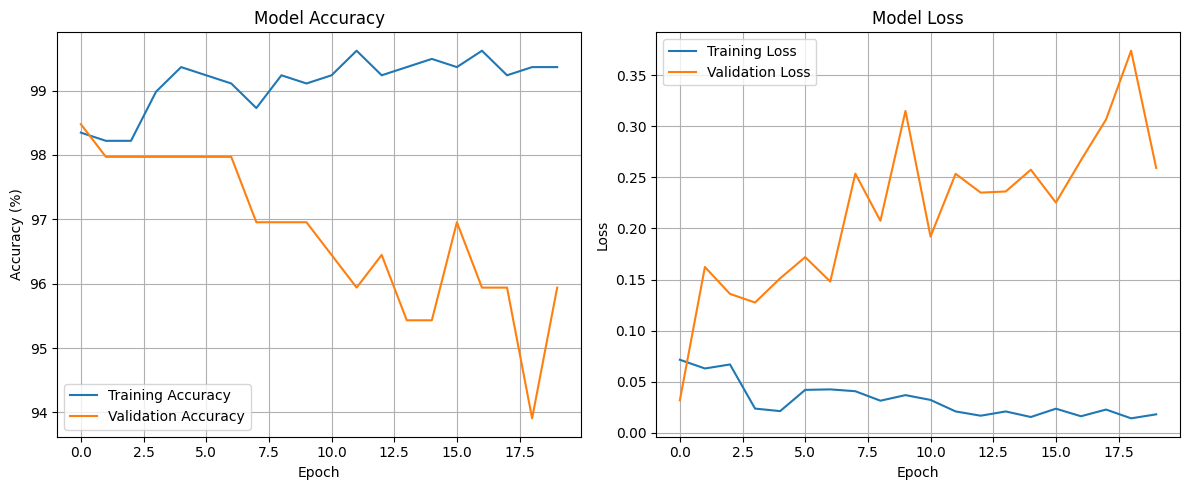

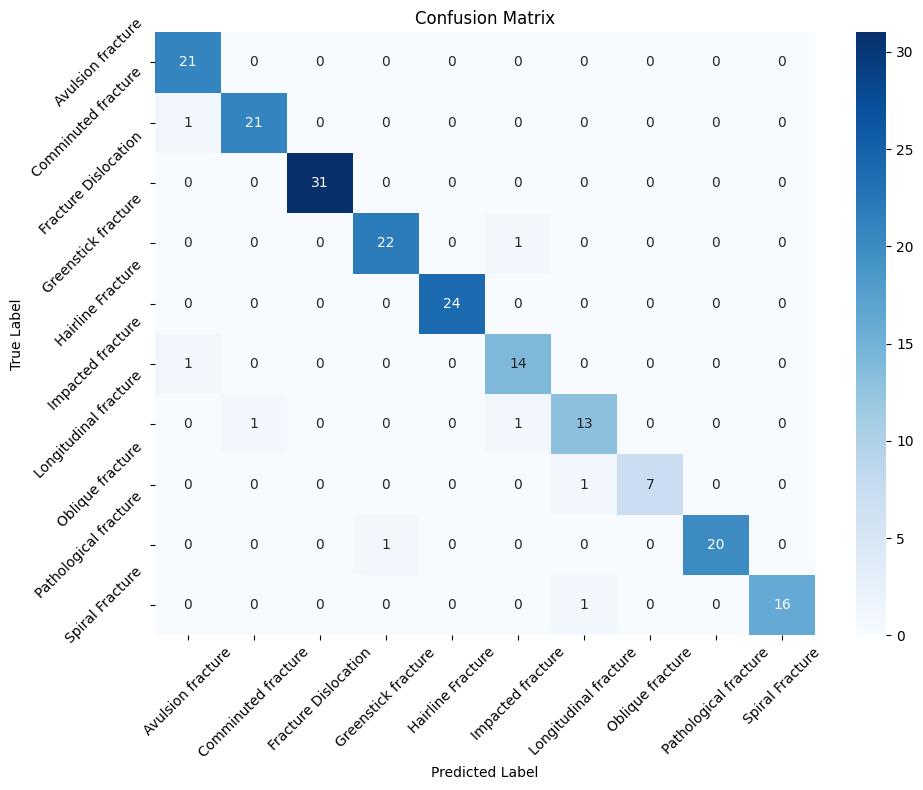

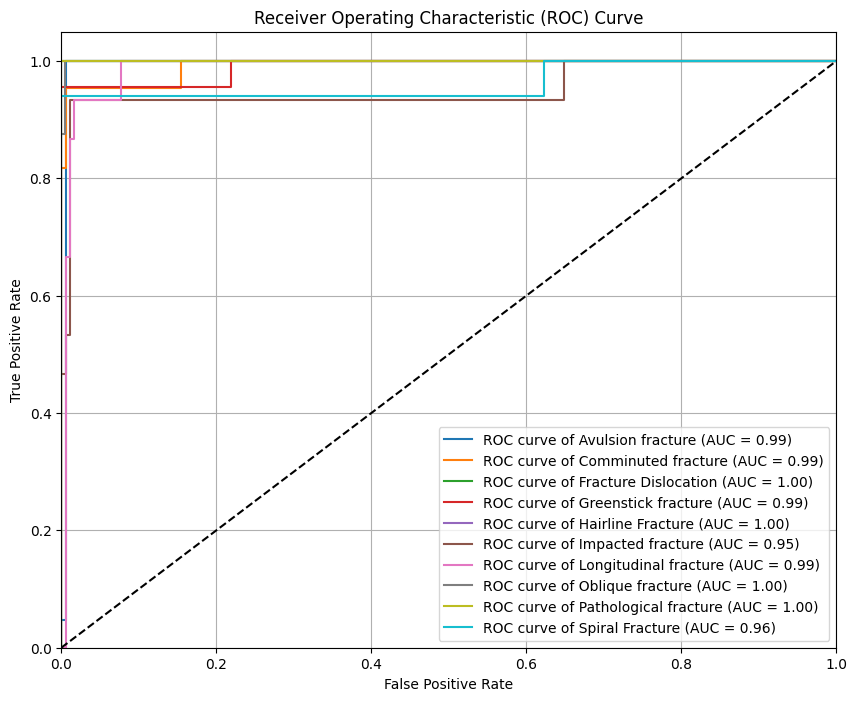


Classification Report:
                       precision    recall  f1-score   support

    Avulsion fracture      0.913     1.000     0.955        21
  Comminuted fracture      0.955     0.955     0.955        22
 Fracture Dislocation      1.000     1.000     1.000        31
  Greenstick fracture      0.957     0.957     0.957        23
    Hairline Fracture      1.000     1.000     1.000        24
    Impacted fracture      0.875     0.933     0.903        15
Longitudinal fracture      0.867     0.867     0.867        15
     Oblique fracture      1.000     0.875     0.933         8
Pathological fracture      1.000     0.952     0.976        21
      Spiral Fracture      1.000     0.941     0.970        17

             accuracy                          0.959       197
            macro avg      0.957     0.948     0.951       197
         weighted avg      0.961     0.959     0.960       197



In [23]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix, classification_report, roc_curve, auc
from sklearn.preprocessing import label_binarize
import torch
import torch.nn as nn
from torch.utils.data import DataLoader
import itertools

class ModelEvaluator:
    def __init__(self, model, device, num_classes, class_names):
        self.model = model
        self.device = device
        self.num_classes = num_classes
        self.class_names = class_names
        self.train_losses = []
        self.train_accuracies = []
        self.val_losses = []
        self.val_accuracies = []
        
    def train_epoch(self, train_loader, criterion, optimizer, epoch, num_epochs):
        self.model.train()
        running_loss = 0.0
        correct = 0
        total = 0
        
        for images, labels in train_loader:
            images, labels = images.to(self.device), labels.to(self.device)
            
            optimizer.zero_grad()
            outputs = self.model(images)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()
            
            running_loss += loss.item()
            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()
        
        epoch_loss = running_loss / len(train_loader)
        epoch_acc = 100 * correct / total
        self.train_losses.append(epoch_loss)
        self.train_accuracies.append(epoch_acc)
        
        print(f"Epoch [{epoch+1}/{num_epochs}], "
              f"Training Loss: {epoch_loss:.4f}, "
              f"Training Accuracy: {epoch_acc:.2f}%")
        
    def validate_epoch(self, val_loader, criterion):
        self.model.eval()
        running_loss = 0.0
        correct = 0
        total = 0
        
        with torch.no_grad():
            for images, labels in val_loader:
                images, labels = images.to(self.device), labels.to(self.device)
                outputs = self.model(images)
                loss = criterion(outputs, labels)
                
                running_loss += loss.item()
                _, predicted = torch.max(outputs.data, 1)
                total += labels.size(0)
                correct += (predicted == labels).sum().item()
        
        epoch_loss = running_loss / len(val_loader)
        epoch_acc = 100 * correct / total
        self.val_losses.append(epoch_loss)
        self.val_accuracies.append(epoch_acc)
        
        return epoch_loss, epoch_acc

    def plot_training_history(self):
        plt.figure(figsize=(12, 5))
        
        # Plot training & validation accuracy
        plt.subplot(1, 2, 1)
        plt.plot(self.train_accuracies, label='Training Accuracy')
        plt.plot(self.val_accuracies, label='Validation Accuracy')
        plt.xlabel('Epoch')
        plt.ylabel('Accuracy (%)')
        plt.title('Model Accuracy')
        plt.legend()
        plt.grid(True)
        
        # Plot training & validation loss
        plt.subplot(1, 2, 2)
        plt.plot(self.train_losses, label='Training Loss')
        plt.plot(self.val_losses, label='Validation Loss')
        plt.xlabel('Epoch')
        plt.ylabel('Loss')
        plt.title('Model Loss')
        plt.legend()
        plt.grid(True)
        
        plt.tight_layout()
        plt.show()

    def plot_confusion_matrix(self, val_loader):
        self.model.eval()
        all_preds = []
        all_labels = []
        
        with torch.no_grad():
            for images, labels in val_loader:
                images = images.to(self.device)
                outputs = self.model(images)
                _, predicted = torch.max(outputs, 1)
                all_preds.extend(predicted.cpu().numpy())
                all_labels.extend(labels.numpy())
        
        # Compute confusion matrix
        cm = confusion_matrix(all_labels, all_preds)
        
        # Plot confusion matrix
        plt.figure(figsize=(10, 8))
        sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
                   xticklabels=self.class_names,
                   yticklabels=self.class_names)
        plt.title('Confusion Matrix')
        plt.ylabel('True Label')
        plt.xlabel('Predicted Label')
        plt.xticks(rotation=45)
        plt.yticks(rotation=45)
        plt.tight_layout()
        plt.show()
        
    def plot_roc_curve(self, val_loader):
        self.model.eval()
        all_probs = []
        all_labels = []
        
        with torch.no_grad():
            for images, labels in val_loader:
                images = images.to(self.device)
                outputs = self.model(images)
                probs = torch.softmax(outputs, dim=1)
                all_probs.extend(probs.cpu().numpy())
                all_labels.extend(labels.numpy())
        
        # Convert to numpy arrays
        all_probs = np.array(all_probs)
        all_labels = np.array(all_labels)
        
        # Compute ROC curve and ROC area for each class
        fpr = dict()
        tpr = dict()
        roc_auc = dict()
        
        # Binarize the labels for ROC curve
        all_labels_binary = label_binarize(all_labels, classes=range(self.num_classes))
        
        plt.figure(figsize=(10, 8))
        
        for i in range(self.num_classes):
            fpr[i], tpr[i], _ = roc_curve(all_labels_binary[:, i], all_probs[:, i])
            roc_auc[i] = auc(fpr[i], tpr[i])
            
            plt.plot(fpr[i], tpr[i],
                    label=f'ROC curve of {self.class_names[i]} (AUC = {roc_auc[i]:.2f})')
        
        plt.plot([0, 1], [0, 1], 'k--')
        plt.xlim([0.0, 1.0])
        plt.ylim([0.0, 1.05])
        plt.xlabel('False Positive Rate')
        plt.ylabel('True Positive Rate')
        plt.title('Receiver Operating Characteristic (ROC) Curve')
        plt.legend(loc="lower right")
        plt.grid(True)
        plt.show()

    def print_performance_metrics(self, val_loader):
        self.model.eval()
        all_preds = []
        all_labels = []
        
        with torch.no_grad():
            for images, labels in val_loader:
                images = images.to(self.device)
                outputs = self.model(images)
                _, predicted = torch.max(outputs, 1)
                all_preds.extend(predicted.cpu().numpy())
                all_labels.extend(labels.numpy())
        
        # Print classification report
        print("\nClassification Report:")
        print(classification_report(all_labels, all_preds, 
                                 target_names=self.class_names, 
                                 digits=3))

# Example usage:
def train_and_evaluate_model(model, train_loader, val_loader, num_epochs, device, class_names):
    criterion = nn.CrossEntropyLoss()
    optimizer = torch.optim.Adam(model.parameters(), lr=0.001)
    
    # Initialize evaluator
    evaluator = ModelEvaluator(model, device, len(class_names), class_names)
    
    # Training loop
    for epoch in range(num_epochs):
        evaluator.train_epoch(train_loader, criterion, optimizer, epoch, num_epochs)
        val_loss, val_acc = evaluator.validate_epoch(val_loader, criterion)
        print(f"Validation Loss: {val_loss:.4f}, Validation Accuracy: {val_acc:.2f}%")
    
    # Plot training history
    evaluator.plot_training_history()
    
    # Plot confusion matrix
    evaluator.plot_confusion_matrix(val_loader)
    
    # Plot ROC curve
    evaluator.plot_roc_curve(val_loader)
    
    # Print performance metrics
    evaluator.print_performance_metrics(val_loader)

# To use this code, add these lines after your model definition:
# Import necessary libraries
from sklearn.model_selection import train_test_split
import torch
from torch.utils.data import DataLoader, SubsetRandomSampler

# Split your data into train and validation sets
train_indices, val_indices = train_test_split(
    range(len(train_dataset)),
    test_size=0.2,
    random_state=42
)

# Create samplers for train and validation splits
train_sampler = SubsetRandomSampler(train_indices)
val_sampler = SubsetRandomSampler(val_indices)

# Create data loaders with the samplers
train_loader = DataLoader(
    train_dataset, 
    batch_size=16, 
    sampler=train_sampler
)
val_loader = DataLoader(
    train_dataset, 
    batch_size=16, 
    sampler=val_sampler
)

# Train and evaluate the model
train_and_evaluate_model(
    model=model,
    train_loader=train_loader,
    val_loader=val_loader,
    num_epochs=20,
    device=device,
    class_names=fracture_types
)